# Полиномиальная регрессия в SciKit-Learn

## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Данные


In [4]:
df = pd.read_csv("Advertising.csv")

In [5]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [6]:
# Берём все колонки, КРОМЕ sales
X = df.drop('sales',axis=1)

In [6]:
y = df['sales']

## Полиномиальная регрессия

**Прежде всего импортируем из Preprocessing класс PolynomialFeatures. С его помощью мы трансформируем наши исходные данные, добавляя в них полиномиальные признаки.**

Мы перейдём от уравнения в следующей форме (здесь показан случай, когда у нас только один признак x):

$$\hat{y} = \beta_0 + \beta_1x_1 + \epsilon $$

и добавим дополнительные признаки на основе исходного признака x для полинома некоторой степени *d*.

$$\hat{y} = \beta_0 + \beta_1x_1 + \beta_1x^2_1 +  ... + \beta_dx^d_1 + \epsilon$$

Далее мы применим линейную регрессию, поскольку по сути мы можем воспринимать эти полиномиальные признаки x^2, x^3, ... x^d как новые признаки. Конечно, нам нужно аккуратно выбрать правильное значение *d*, степень нашей модели. В этом нам помогут наши метрики оценки модели

**Также нужно заметить, что когда у нас есть несколько признаков на основе признака X, то метод PolynomialFeatures также будет рассматривать *комбинации* признаков. Например, если на входе мы имеем два измерения в виде [a, b], то полином второй степени имеет следующие признаки: [1, a, b, a^2, ab, b^2].**

In [7]:
from sklearn.preprocessing import PolynomialFeatures

In [8]:
polynomial_converter = PolynomialFeatures(degree=2,include_bias=False)

In [ ]:
# Анализ признаков с помощью метода .fit()
polynomial_converter.fit(X)

In [ ]:
# Создание полиномиальных признаков с помощью метода .transform()
poly_features = polynomial_converter.transform(X)

In [9]:
# poly_features = polynomial_converter.fit_transform(X)

In [10]:
poly_features.shape

(200, 9)

In [11]:
X.shape

(200, 3)

In [12]:
X.iloc[0]

TV           230.1
radio         37.8
newspaper     69.2
Name: 0, dtype: float64

In [13]:
poly_features[0]

array([2.301000e+02, 3.780000e+01, 6.920000e+01, 5.294601e+04,
       8.697780e+03, 1.592292e+04, 1.428840e+03, 2.615760e+03,
       4.788640e+03])

In [14]:
poly_features[0][:3]

array([230.1,  37.8,  69.2])

In [15]:
poly_features[0][:3]**2

array([52946.01,  1428.84,  4788.64])

Комбинации признаков $$x_1  \cdot x_2 \text{  и  } x_1  \cdot x_3 \text{  и  }   x_2  \cdot x_3 $$

In [16]:
230.1*37.8

8697.779999999999

In [17]:
230.1*69.2

15922.92

In [18]:
37.8*69.2

2615.7599999999998

## Разбиение на обучающий и тестовый наборы данных - Train | Test Split

In [19]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)

### Модель для обучения на полиномиальных данных

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
model = LinearRegression()

In [24]:
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
test_predictions = model.predict(X_test)

In [ ]:
model.coef_

In [26]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [27]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [28]:
MAE

0.489679804480361

In [29]:
MSE

0.4417505510403426

In [30]:
RMSE

0.6646431757269028

In [31]:
df['sales'].mean()

14.022500000000003

### Сравнение с простой линейной регрессией

**Результаты на тестовом наборе данных (замечание: для правильного сравнения следует использовать одно и то же разбиение данных на обучающую и тестовую выборки!)**

* Простая линейная регрессия:
    * MAE: 1.213
    * RMSE: 1.516

* Полиномиальная регрессия 2й степени:
    * MAE: 0.4896
    * RMSE: 0.664

## Выбираем модель

### Подбор параметров

Может быть, более высокая степень полинома ещё больше улучшит результаты? Но не будет ли так, что большие значения степени будут слишком большими? Давайте посмотрим на дальнейшие степени полиномов, каждый раз смотря на ошибки предсказания. 
Давайте с помощью цикла for сделаем следующее:
1. Создадим полиномиальные данные некоторой степени для данных X
2. Разобъём полиномиальные данные для обучающий и тестовый наборы данных
3. Выполним обучение модели на обучающем наборе данных
4. Посчитаем метрики на обучающем *и* тестовом наборе данных
5. Нанесём эти данные на график, чтобы увидеть момент переобучения модели

In [32]:
# Ошибка на обучающем наборе для той или иной степени полинома
train_rmse_errors = []
# Ошибка на тестовом наборе для той или иной степени полинома
test_rmse_errors = []

for d in range(1,10):
    
    # Создаём полиномиальные данные для степени "d"
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    
    # Разбиваем эти новые полиномиальные данные на обучающий и тестовый наборы данных
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)
    
    # Обучаем модель на этом новом наборе полиномиальных данных
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    # Выполняем предсказание и на обучающем, и на тестовом наборе данных
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Вычисляем ошибки
    
    # Ошибки на обучающем наборе данных
    train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
    
    # Ошибки на тестовом наборе данных
    test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))

    # Добавляем ошибки в список для последующего нанесения на график
       
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)

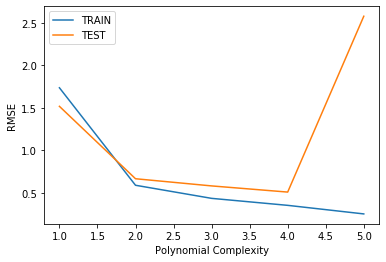

In [33]:
plt.plot(range(1,6),train_rmse_errors[:5],label='TRAIN')
plt.plot(range(1,6),test_rmse_errors[:5],label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.legend()

## Финальный выбор модели

Здесь нам нужно сохранить 2 вещи - объект создания полиномиальных признаков, а также саму модель. Дальнейшие шаги будут следующие:

1. Выбираем финальные значения параметров на основе тестовых метрик
2. Выполняем повторное обучение на всех данных
3. Сохраняем объект Polynomial Converter
4. Сохраняем модель

In [42]:
# На нашем графике видно, что мы могли бы выбрать и значение degree=4, однако
# безопаснее взять чуть меньшую степень сложности
final_poly_converter = PolynomialFeatures(degree=3,include_bias=False)

In [43]:
final_model = LinearRegression()

In [45]:
final_model.fit(final_poly_converter.fit_transform(X),y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Сохраняем модель и объект converter

In [46]:
from joblib import dump, load

In [49]:
dump(final_model, 'sales_poly_model.joblib') 

['sales_poly_model.joblib']

In [50]:
dump(final_poly_converter,'poly_converter.joblib')

['poly_converter.joblib']

## Внедрение модели и предсказания

### Предсказания на новых данных

Вспомните, что нам нужно **сконвертировать** новые входящие данные в полиномиальные данные, поскольку именно на таких данных мы обучали нашу модель. Мы можем загрузить ранее сохранённый объект converter и просто вызвать метод **.transform()** на новых данных, поскольку нам не нужно выполнять обучение на новых данных.

**В нашей следующей рекламной кампании мы планируем потратить 149k на рекламу на ТВ, 22k на рекламу по радио и 12k на рекламу в газетах. Сколько единиц товара мы ожидаем продать в результате такой рекламы?**

In [62]:
loaded_poly = load('poly_converter.joblib')
loaded_model = load('sales_poly_model.joblib')

In [63]:
campaign = [[149,22,12]]

In [64]:
campaign_poly = loaded_poly.transform(campaign)

In [65]:
campaign_poly

array([[1.490000e+02, 2.200000e+01, 1.200000e+01, 2.220100e+04,
        3.278000e+03, 1.788000e+03, 4.840000e+02, 2.640000e+02,
        1.440000e+02, 3.307949e+06, 4.884220e+05, 2.664120e+05,
        7.211600e+04, 3.933600e+04, 2.145600e+04, 1.064800e+04,
        5.808000e+03, 3.168000e+03, 1.728000e+03]])

In [67]:
final_model.predict(campaign_poly)

array([14.64501014])